## Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, KFold, learning_curve, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import itertools

sns.set_style('whitegrid')

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

### Creating Data Set

In [2]:
Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)
Salaries.shape

(23860, 395)

### Drop rows missing target variable

In [3]:
Salaries.dropna(subset=['Q9'],inplace=True)

## Data Cleaning

In [4]:
Salaries.Q9.unique()

array(['What is your current yearly compensation (approximate $USD)?',
       '10-20,000', '0-10,000',
       'I do not wish to disclose my approximate yearly compensation',
       '20-30,000', '125-150,000', '30-40,000', '50-60,000',
       '100-125,000', '90-100,000', '70-80,000', '80-90,000', '60-70,000',
       '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

In [5]:
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"] #For dropping the rows where salary is not disclosed

In [6]:
Salaries.loc[1:,'index'] = Salaries[1:].reset_index().index #To add a index column

### Selecting the non useful Columns 
1. Time taken to fill the survey does not help in determing the salary of the person
2. Q18 - Recommendation is not useful in determing the salary of the person
3. Q23 - In my opinion data analysis is how you get insight from the data and not how much time you spent on coding thus it is not useful in determing the salary of the person
4. Q26 - Opinion is not useful in determing the salary of the person
5. Q37 - Same as Q36 it will cause overfitting the model
6. Q40 - Recommendation is not useful in determing the salary of the person
7. Q43 - In my opinion the type of data set might not be helpful in determing the salary of the person
8. Q46 - In my opinion the type of project might not be helpful in determing the salary of the person
9. Q48 - Opinion is not useful in determing the salary of the person

In [7]:
Salaries = Salaries.drop([0], axis=0) #Dropping the questions row
#Code to drop single columns
Salaries.drop(labels=['Time from Start to Finish (seconds)', 'Q18', 'Q23', 'Q26', 'Q37', 'Q40', 'Q43', 'Q46', 'Q48'], axis=1, inplace=True)

### Selecting the non useful Questions
Q16, 19, 21, 31 are same as Q17, 20, 22, 32 and this would result in overfitting the data.

Rest of the questions relate to opinoins; recommendations; which platform did they use for study; resources and which media do they follow, which will not be helpful in determing the salary of the person.

Q34 - In my opinion the time spent on each module of data projects has no connection with determing the salary of the person

In [8]:
# Code to select multiple columns
ctod = ['_OTHER', 'Q33', 'Q34', 'Q35', 'Q36', 'Q38', 'Q39', 'Q44', 'Q45', 'Q49', 'Q50', 'Q12_Part', 'Q16', 'Q19', 'Q21', 'Q31',
       'Q41', 'Q47']

cols_append = []

for i in ctod:
    df = Salaries.filter(regex=i) 
    cols_append.append(df.columns)

cols_to_drop = list(itertools.chain.from_iterable(cols_append))

In [9]:
Salaries.drop(labels=cols_to_drop, axis=1, inplace=True) #Dropping the irrelevant columns

In [10]:
Salaries.Q2.unique() #Checking for any undesired entries in a column

array(['30-34', '22-24', '35-39', '18-21', '40-44', '25-29', '55-59',
       '60-69', '45-49', '50-54', '80+', '70-79'], dtype=object)

In [11]:
Salaries.Q8.unique() #Checking for any undesired entries in a column

array(['5-10', '0-1', '10-15', '3-4', nan, '1-2', '2-3', '15-20', '4-5',
       '25-30', '20-25', '30 +'], dtype=object)

In [12]:
Salaries.Q8.value_counts(dropna = False)

0-1      3879
1-2      2826
5-10     1973
2-3      1965
3-4      1308
4-5      1145
10-15    1123
15-20     595
20-25     271
30 +      144
25-30     124
NaN        76
Name: Q8, dtype: int64

Filling the NaN data with random value as mode doesn't span much of the data

In [13]:
random.seed(1)
Salaries['Q8'].fillna(random.choice(Salaries['Q8'].dropna().values), inplace= True) 

As my split('-') won't be able to identify + thus changing the + to - and after dropping the rows again replace the - with the +.

In [14]:
change = Salaries[Salaries['Q2'] == '80+'].index   
for i in change:
    Salaries.at[i,'Q2'] = '80-'

#### Removing those rows where the difference between age and experience is less than 10 years as it is not possible to have experience in that role since the person was age 10. It is possible in 2 cases either the person didn’t understood the question or was not taking the survey seriously.

In [15]:
compare = Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=40) & (Salaries['Q8'] == '30 +')]
compare = compare.append(Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=30) & (Salaries['Q8'] == '25-30')])
compare = compare.append(Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=30) & (Salaries['Q8'] == '20-25')])
compare = compare.append(Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=25) & (Salaries['Q8'] == '15-20')])
compare = compare.append(Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=22) & (Salaries['Q8'] == '10-15')])
compare = compare.append(Salaries[(Salaries['Q2'] =='18-21') & (Salaries['Q8'] == '5-10')])
rows_to_drop = compare.index

In [16]:
Salaries.drop(labels=rows_to_drop, axis = 0, inplace = True)

In [17]:
change1 = Salaries[Salaries['Q9'] == '500,000+'].index   
for i in change1:
    Salaries.at[i,'Q9'] = '600000-'

In [18]:
change2 = Salaries[Salaries['Q8'] == '30 +'].index   
for i in change2:
    Salaries.at[i,'Q8'] = '30-'

In [19]:
row_drop = []
# It is not possible for a person less than 60 years old to have a salary more than 300,000
row_drop = Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <60) & (pd.to_numeric(Salaries['Q9'].str.split('-').str[0]) >=300)]
# It is not possible for a person less than 22 years old to have a salary more than 200,000
row_drop = row_drop.append(Salaries[(pd.to_numeric(Salaries['Q2'].str.split('-').str[0]) <=22) & (pd.to_numeric(Salaries['Q9'].str.split('-').str[0]) >=200)])
# It is not possible for a person with less than 2 years experience to have a salary more than 200,000
row_drop = row_drop.append(Salaries[(pd.to_numeric(Salaries['Q8'].str.split('-').str[0]) <=1) & (pd.to_numeric(Salaries['Q9'].str.split('-').str[0]) >=200)])
row_drop = row_drop.index
# Removing any duplicate indexes from the list
mylist = list(dict.fromkeys(row_drop))

Salaries.drop(labels=mylist, axis = 0, inplace = True)

In [20]:
Salaries_new = Salaries.copy(deep =True) #creating a copy of the cleaned data frame

#### Analysis of single columns with mutiple entries is easy that's why I am breaking the data frame into 2, Here i will be cleaning the data in the single columns with multiple entries

In [21]:
pop_list = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q12_MULTIPLE_CHOICE', 'Q17', 'Q20', 'Q22', 'Q24', 'Q25', 'Q32']
Single_col = pd.DataFrame([Salaries_new.pop(x) for x in pop_list]).T 

In [22]:
Single_col.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q12_MULTIPLE_CHOICE,Q17,Q20,Q22,Q24,Q25,Q32
count,15020,15020,15020,15020,14894,15020,15020,15020,15020,14745,13533,10820,9452,9008,13140,13115,10078
unique,4,12,58,7,13,20,19,11,18,6,6,17,18,12,10,10,12
top,Male,25-29,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,Computers/Technology,0-1,"0-10,000",We are exploring ML methods (and may one day p...,Local or hosted development environments (RStu...,Python,Scikit-Learn,Matplotlib,1-2 years,< 1 year,Numerical Data
freq,12550,4223,3278,7121,5754,3206,4107,3844,4182,3393,6779,5714,4425,4808,3711,4094,2583


Plot to check the NaN distribution in Single_col dataframe

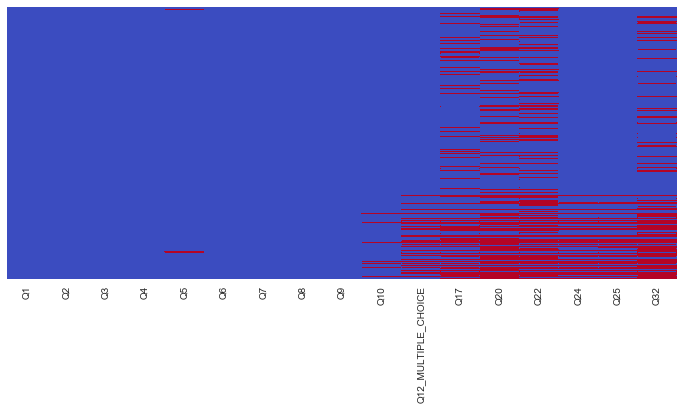

In [23]:
# Heatmap of the null values in the Single_col dataframe
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(Single_col.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax) 
plt.show()

In [24]:
Single_col.Q1.unique() #Checking for any undesired entries in a column

array(['Male', 'Female', 'Prefer not to say', 'Prefer to self-describe'],
      dtype=object)

In [25]:
len(Single_col[Single_col['Q1']== "Prefer not to say"]) 

122

In [26]:
len(Single_col[Single_col['Q1']== "Prefer to self-describe"])

47

Setting the threshold for null value imputation with the mode if the mode spans atleast 35% of the data. Checking the Single_col describe(), as more than 35% of the data is Male then replacing the values with Male as it won't make much difference as we are imputing for just 168 data points which is approximately 1% of all data points.

In [27]:
Single_col.at[Single_col['Q1']== "Prefer not to say", 'Q1'] = 'Male' 
Single_col.at[Single_col['Q1']== "Prefer to self-describe", 'Q1'] = 'Male' 

In [28]:
Single_col.Q3.unique() #Checking for any undesired entries in a column

array(['Indonesia', 'United States of America', 'India', 'Chile',
       'Hungary', 'France', 'Argentina', 'Japan', 'Colombia', 'Nigeria',
       'Spain', 'Other', 'Iran, Islamic Republic of...',
       'United Kingdom of Great Britain and Northern Ireland', 'Turkey',
       'Poland', 'Kenya', 'Denmark', 'Netherlands', 'Sweden', 'Ukraine',
       'Canada', 'Australia', 'Russia', 'Italy', 'Mexico', 'Germany',
       'I do not wish to disclose my location', 'Singapore', 'Brazil',
       'China', 'South Africa', 'South Korea', 'Malaysia',
       'Hong Kong (S.A.R.)', 'Portugal', 'Thailand', 'Morocco',
       'Pakistan', 'Tunisia', 'Ireland', 'Israel', 'Switzerland',
       'Bangladesh', 'Romania', 'Austria', 'Belarus', 'Viet Nam',
       'Czech Republic', 'Philippines', 'Belgium', 'New Zealand',
       'Norway', 'Finland', 'Egypt', 'Greece', 'Peru',
       'Republic of Korea'], dtype=object)

In [29]:
len(Single_col[Single_col['Q3']== "I do not wish to disclose my location"])

139

Checking the Single_col describe(), as the mode doesn't span much of the data then filling the Undesired data with random value.

In [30]:
random.seed(1)
listq = Single_col[Single_col['Q3']== "I do not wish to disclose my location"].index
varsw = random.choice(Single_col[Single_col['Q3']!= "I do not wish to disclose my location"]['Q3'])
for i in listq:
    Single_col.at[i,'Q3'] = varsw

In [31]:
Single_col.Q4.unique() #Checking for any undesired entries in a column

array(['Bachelor’s degree', 'Master’s degree', 'Doctoral degree',
       'Professional degree',
       'Some college/university study without earning a bachelor’s degree',
       'I prefer not to answer', 'No formal education past high school'],
      dtype=object)

In [32]:
len(Single_col[Single_col['Q4']== "I prefer not to answer"]) 

125

Checking the Single_col describe(), as more than 35% of the data is Master’s degree then replacing the values with Master’s degree as it won't make much difference as we are imputing for just 125 data points which is not even 1% of all data points.

In [33]:
Single_col.at[Single_col['Q4']== "I prefer not to answer", 'Q4'] = 'Master’s degree'

In [34]:
Single_col.Q5.unique() #Checking for any undesired entries in a column

array(['Engineering (non-computer focused)',
       'Computer science (software engineering, etc.)',
       'Mathematics or statistics',
       'Information technology, networking, or system administration',
       'A business discipline (accounting, economics, finance, etc.)',
       'Environmental science or geology',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'I never declared a major', 'Other', 'Physics or astronomy',
       'Social sciences (anthropology, psychology, sociology, etc.)',
       'Humanities (history, literature, philosophy, etc.)', nan,
       'Fine arts or performing arts'], dtype=object)

In [35]:
len(Single_col[Single_col['Q5']== "I never declared a major"]) 

65

Checking the Single_col describe(), as more than 35% of the data is Computer science (software engineering, etc.) then replacing the values with Computer science (software engineering, etc.) as it won't make much difference as we are imputing for just 65 data points.

In [36]:
Single_col.at[Single_col['Q5']== "I never declared a major", 'Q5'] = 'Computer science (software engineering, etc.)'

In [37]:
Single_col['Q5'].fillna('Computer science (software engineering, etc.)', inplace= True)

In [38]:
Single_col.Q6.unique() #Checking for any undesired entries in a column

array(['Other', 'Data Scientist', 'Data Analyst', 'Software Engineer',
       'Student', 'Research Assistant', 'Chief Officer', 'Manager',
       'Research Scientist', 'Business Analyst', 'Consultant',
       'Data Engineer', 'Developer Advocate', 'Product/Project Manager',
       'Marketing Analyst', 'Principal Investigator', 'Salesperson',
       'DBA/Database Engineer', 'Statistician', 'Data Journalist'],
      dtype=object)

In [39]:
Single_col.Q7.unique() #Checking for any undesired entries in a column

array(['Manufacturing/Fabrication', 'I am a student',
       'Academics/Education', 'Other',
       'Online Service/Internet-based Services', 'Medical/Pharmaceutical',
       'Energy/Mining', 'Retail/Sales', 'Military/Security/Defense',
       'Computers/Technology', 'Insurance/Risk Assessment',
       'Hospitality/Entertainment/Sports', 'Broadcasting/Communications',
       'Accounting/Finance', 'Shipping/Transportation',
       'Online Business/Internet-based Sales',
       'Government/Public Service', 'Non-profit/Service', 'Marketing/CRM'],
      dtype=object)

In [40]:
Single_col.Q10.unique() #Checking for any undesired entries in a column

array(['No (we do not use ML methods)', 'I do not know',
       'We recently started using ML methods (i.e., models in production for less than 2 years)',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'We are exploring ML methods (and may one day put a model into production)',
       'We use ML methods for generating insights (but do not put working models into production)',
       nan], dtype=object)

### Feature Engineering 1
We recently started using ML methods (i.e., models in production for less than 2 years), We have well established ML methods (i.e., models in production for more than 2 years), We use ML methods for generating insights (but do not put working models into production) all belong in the category of Yes for the question Does your current employer incorporate machine learning methods into their business? Thus reducing the number of response categories.

In [41]:
Single_col.Q10.value_counts(dropna = False)

We are exploring ML methods (and may one day put a model into production)                    3393
No (we do not use ML methods)                                                                3321
We recently started using ML methods (i.e., models in production for less than 2 years)      2951
We have well established ML methods (i.e., models in production for more than 2 years)       2184
We use ML methods for generating insights (but do not put working models into production)    1606
I do not know                                                                                1290
NaN                                                                                           275
Name: Q10, dtype: int64

In [42]:
Single_col.at[Single_col['Q10']== "No (we do not use ML methods)", 'Q10'] = 'No'
Single_col.at[Single_col['Q10']== "We recently started using ML methods (i.e., models in production for less than 2 years)", 'Q10'] = 'Yes'
Single_col.at[Single_col['Q10']== "We have well established ML methods (i.e., models in production for more than 2 years)", 'Q10'] = 'Yes'
Single_col.at[Single_col['Q10']== "We use ML methods for generating insights (but do not put working models into production)", 'Q10'] = 'Yes'

As mode is more than 35% of the data then replacing the NaN values with the mode as it won't make much difference as we are imputing for 277 data points which is almost 1.7% of all data points.

In [43]:
Single_col['Q10'].fillna(value = 'Yes', inplace = True)

As mode is predominant in the column thus replacing the NaN values with the mode

In [44]:
Single_col['Q12_MULTIPLE_CHOICE'].fillna(value = Single_col['Q12_MULTIPLE_CHOICE'].mode()[0], inplace = True)

As the mode doesn't span much of the data then filling the NaN data with random values for the questions Q17, 20, 22, 24, 25, 32.

In [45]:
random.seed(1)
Single_col['Q17'].fillna(random.choice(Single_col['Q17'].dropna().values), inplace= True)
Single_col['Q20'].fillna(random.choice(Single_col['Q20'].dropna().values), inplace= True)
Single_col['Q22'].fillna(random.choice(Single_col['Q22'].dropna().values), inplace= True) 
Single_col['Q24'].fillna(random.choice(Single_col['Q24'].dropna().values), inplace= True)
Single_col['Q25'].fillna(random.choice(Single_col['Q24'].dropna().values), inplace= True)
Single_col['Q32'].fillna(random.choice(Single_col['Q32'].dropna().values), inplace= True)
Single_col.describe()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q12_MULTIPLE_CHOICE,Q17,Q20,Q22,Q24,Q25,Q32
count,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020,15020
unique,2,12,57,6,12,20,19,11,18,4,6,17,18,12,10,10,12
top,Male,25-29,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,Computers/Technology,0-1,"0-10,000",Yes,Local or hosted development environments (RStu...,Python,TensorFlow,Seaborn,3-5 years,< 1 year,Numerical Data
freq,12719,4223,3417,7246,5945,3206,4107,3844,4182,7016,8266,5714,6884,6977,4986,4094,7525


## Data Exploration

#### To plot the data with salaries i need to convert the salary buckets to numerics and defing a function for that. Here if the salary bucket is 0-10,000 then it will return 10000 and if the salary is 10-20,000 the function will return 20000 likewise for all the salary buckets.

In [46]:
def salarybreak(range):
    if range == '0-10,000': 
        return 10000
    elif range == '10-20,000':
        return 20000
    elif range == '20-30,000':
        return 30000
    elif range == '30-40,000':
        return 40000
    elif range == '40-50,000':
        return 50000
    elif range == '50-60,000':
        return 60000
    elif range == '60-70,000':
        return 70000
    elif range == '70-80,000':
        return 80000
    elif range == '80-90,000':
        return 90000
    elif range == '90-100,000':
        return 100000
    elif range == '100-125,000':
        return 125000
    elif range == '125-150,000':
        return 150000
    elif range == '150-200,000':
        return 200000
    elif range == '200-250,000':
        return 250000
    elif range == '250-300,000':
        return 300000
    elif range == '300-400,000':
        return 400000
    elif range == '400-500,000':
        return 500000
    else:
        return 600000
        

In [47]:
#Creating a new coulmn Q9_New for the numerical salary values
Single_col['Q9_New'] = Single_col.apply(lambda row: salarybreak(row['Q9']),axis=1)

#### Label encoding in the Single_col dataframe to plot the correlation matrix.
I am plotting the correlation matrix because it provides me the correlations for features with respect to each other. Through this I can identify which feature gives more information about determining the target.

As for correlation matrix I do not want to separate the columns, if I separate the columns then I won't be able to weigh all the factors in a particular column as a single column and give the correlation, instead i would be giving the correlation with respect to the new columns formed which is not correct. In order to encode all the unique values in each coulmns and not separate the columns LabelEncoder is used. 

In [48]:
temp_df1 = Single_col.copy(deep =True)
le_df = temp_df1.drop(['Q9', 'Q9_New'], axis = 1)
le = LabelEncoder()
le_df = le_df.apply(le.fit_transform)
le_df = pd.concat([temp_df1.pop('Q9_New'), le_df ], axis = 1)
le_df.head()

,Q9_New,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q12_MULTIPLE_CHOICE,Q17,Q20,Q22,Q24,Q25,Q32
2,20000,1,3,21,0,2,11,9,10,1,1,11,12,9,9,9,5
3,10000,0,3,55,2,1,7,7,0,0,4,4,12,11,6,7,10
5,10000,1,1,20,2,7,4,7,0,0,0,14,12,9,6,2,5
7,20000,1,4,8,1,6,11,0,2,1,1,11,12,9,7,7,5
8,10000,1,0,20,2,6,11,16,0,3,4,11,5,6,7,7,4


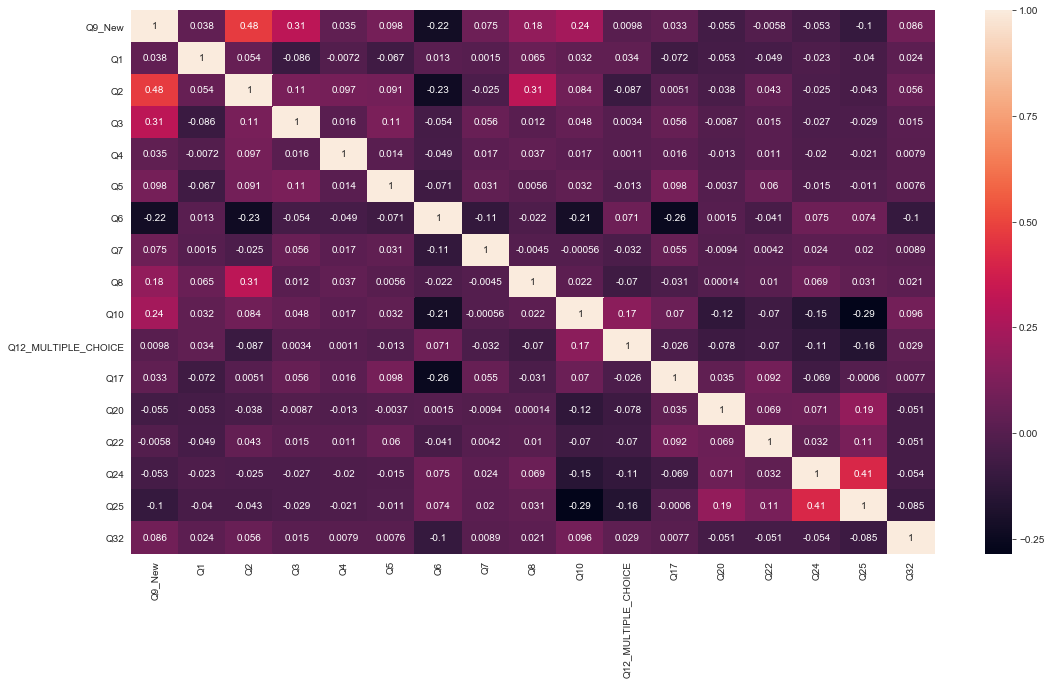

In [49]:
corr = le_df.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)
plt.show()

From the correlation matrix it can be inferred that the columns Q2, Q3, Q10 and Q8 show good positive correlation with the salary. Thus plotting these features with salary and verifying the correlation found from the correlation matrix

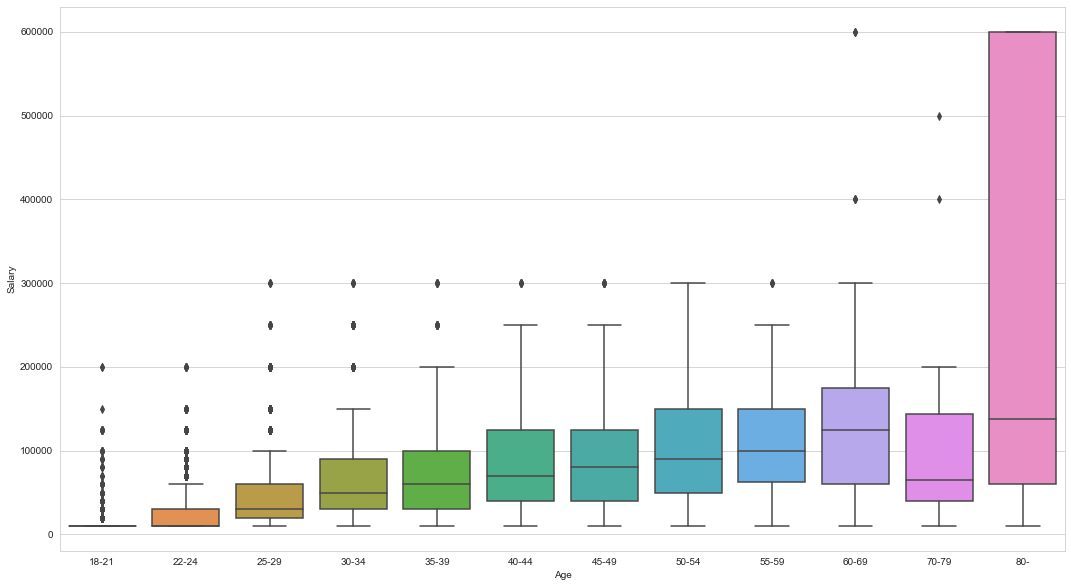

In [50]:
plt.figure(figsize=(18,10))
age = sns.boxplot(x='Q2', y='Q9_New', data=Single_col.sort_values(by=['Q2']))
plt.xlabel('Age')
plt.ylabel('Salary')
plt.show()

From the graph it can be interpreted that there is a positive correlation of age with salary as the age increases the salary also increases.

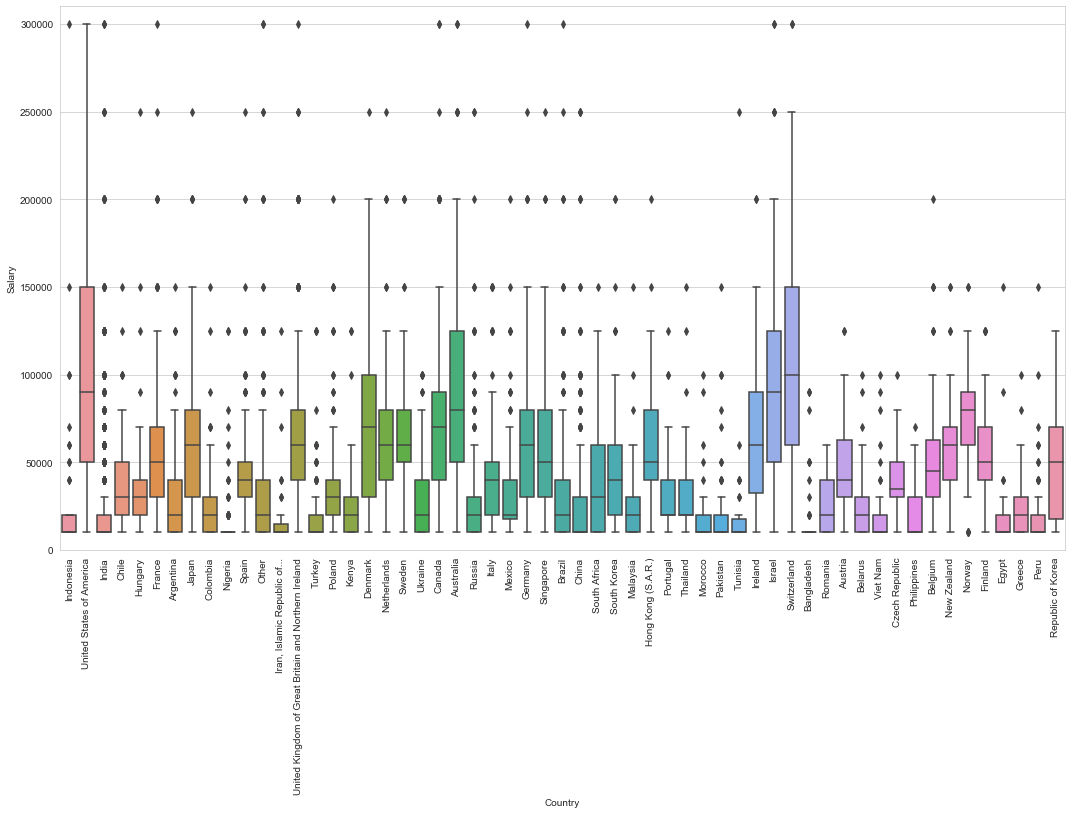

In [51]:
plt.figure(figsize=(18,10))
country = sns.boxplot(x='Q3', y='Q9_New', data=Single_col)
country.set(ylim=(0, 310000))
country.set_xticklabels(country.get_xticklabels(),rotation=90) 
plt.xlabel('Country')
plt.ylabel('Salary')
plt.show()

From the graph it can be interpreted that there is a positive correlation of country with salary for countries like USA and Switzerland the salaries are quite high. Countries like Nigeria and Bangladesh offer very low salary.

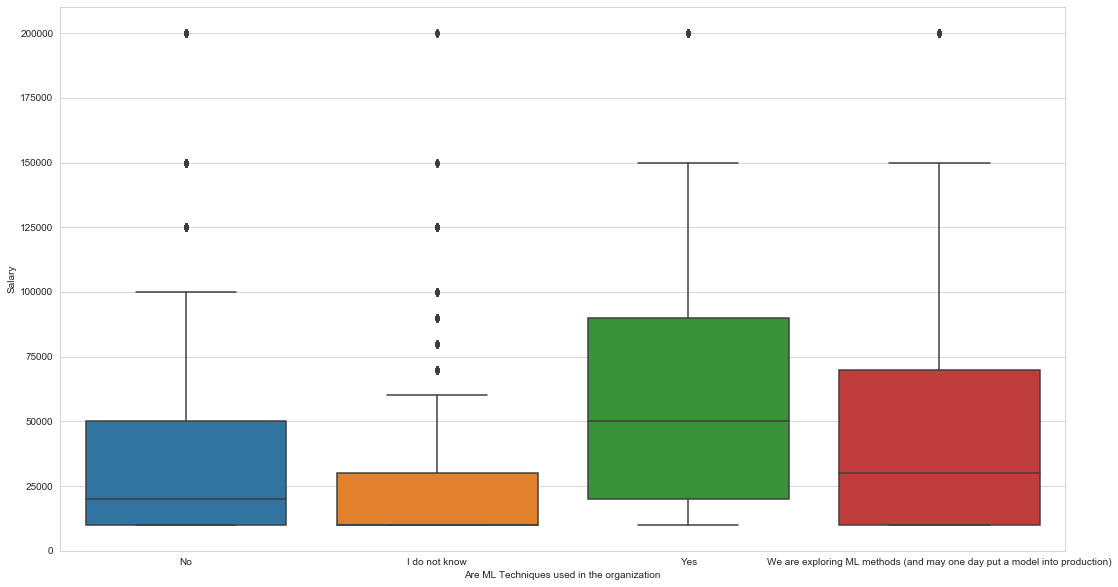

In [52]:
plt.figure(figsize=(18,10))
ML = sns.boxplot(x='Q10', y='Q9_New', data=Single_col)
ML.set(ylim=(0, 210000))
plt.xlabel('Are ML Techniques used in the organization')
plt.ylabel('Salary')
plt.show()

From the plot we can infer that if the organization is exploring ML or using it gives more salary to their employees compared to the organizations who do not use ML techniques.

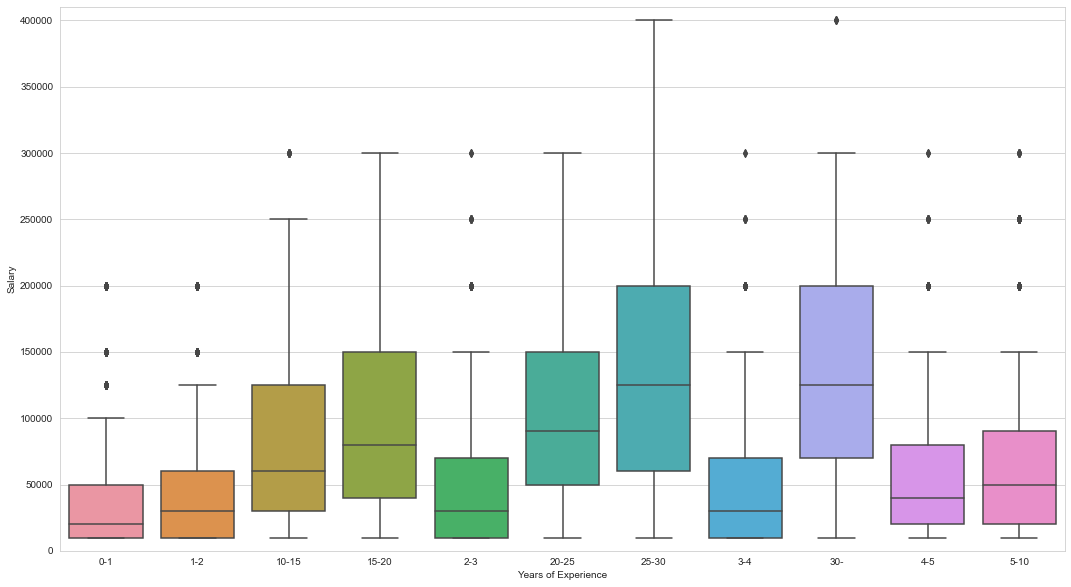

In [53]:
plt.figure(figsize=(18,10))
experience = sns.boxplot(x='Q8', y='Q9_New', data=Single_col.sort_values(by=['Q8']))
experience.set(ylim=(0, 410000))
plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.show()

From the graph it can be interpreted that there is a positive correlation of experience with salary as the experience increases the salary also increases.

In [54]:
Single_col.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q12_MULTIPLE_CHOICE,Q17,Q20,Q22,Q24,Q25,Q32,Q9_New
2,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No,"Basic statistical software (Microsoft Excel, G...",R,TensorFlow,Seaborn,I have never written code but I want to learn,I have never studied machine learning but plan...,Numerical Data,20000
3,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,Local or hosted development environments (RStu...,Java,TensorFlow,ggplot2,5-10 years,< 1 year,Time Series Data,10000
5,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000",I do not know,"Advanced statistical software (SPSS, SAS, etc.)",SQL,TensorFlow,Seaborn,5-10 years,2-3 years,Numerical Data,10000
7,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000",No,"Basic statistical software (Microsoft Excel, G...",R,TensorFlow,Seaborn,< 1 year,< 1 year,Numerical Data,20000
8,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000",Yes,Local or hosted development environments (RStu...,R,Keras,Matplotlib,< 1 year,< 1 year,Image Data,10000


#### Performing one hot encoding on Single_col dataframe
We need to convert categorical data into numerical data as Sklearn doesn't take categorical values as input.
Here we are separating all the unique values in all the columns into different columns with only one values and encoding it in 0 and 1. If we labelencode here then there will be weightage assigned to the entries in the column which is not needed.

In [55]:
# Create dummy features for each categorical feature
dummies_Q1_Single_col = pd.get_dummies(Single_col['Q1'], prefix='Q1')
dummies_Q2_Single_col = pd.get_dummies(Single_col['Q2'], prefix='Q2')
dummies_Q3_Single_col = pd.get_dummies(Single_col['Q3'], prefix='Q3')
dummies_Q4_Single_col = pd.get_dummies(Single_col['Q4'], prefix='Q4')
dummies_Q5_Single_col = pd.get_dummies(Single_col['Q5'], prefix='Q5')
dummies_Q6_Single_col = pd.get_dummies(Single_col['Q6'], prefix='Q6')
dummies_Q7_Single_col = pd.get_dummies(Single_col['Q7'], prefix='Q7')
dummies_Q8_Single_col = pd.get_dummies(Single_col['Q8'], prefix='Q8')
dummies_Q10_Single_col = pd.get_dummies(Single_col['Q10'], prefix='Q10')
dummies_Q12_Single_col = pd.get_dummies(Single_col['Q12_MULTIPLE_CHOICE'], prefix='Q12')
dummies_Q17_Single_col = pd.get_dummies(Single_col['Q17'], prefix='Q17')
dummies_Q20_Single_col = pd.get_dummies(Single_col['Q20'], prefix='Q20')
dummies_Q22_Single_col = pd.get_dummies(Single_col['Q22'], prefix='Q22')
dummies_Q24_Single_col = pd.get_dummies(Single_col['Q24'], prefix='Q24')
dummies_Q25_Single_col = pd.get_dummies(Single_col['Q25'], prefix='Q25')
dummies_Q32_Single_col = pd.get_dummies(Single_col['Q32'], prefix='Q32')

# Add the new features to the dataframe via concating
tempDF = pd.concat([Single_col, dummies_Q1_Single_col, dummies_Q2_Single_col, dummies_Q3_Single_col, dummies_Q4_Single_col,
                   dummies_Q5_Single_col, dummies_Q6_Single_col, dummies_Q7_Single_col, dummies_Q8_Single_col,
                   dummies_Q10_Single_col, dummies_Q12_Single_col, dummies_Q17_Single_col, dummies_Q20_Single_col,
                   dummies_Q22_Single_col, dummies_Q24_Single_col, dummies_Q25_Single_col, dummies_Q32_Single_col], axis=1)

# Drop the original categorical feature columns
# Single_col With string values (eg. 0-10,000 etc.) in the target columns
Single_col = tempDF.drop(['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9_New','Q10','Q12_MULTIPLE_CHOICE','Q17','Q20','Q22','Q24','Q25','Q32'],axis=1)
# Single_col2 With numerical values (eg. 10000 etc.) in the target columns
Single_col2 = tempDF.drop(['Q1','Q2','Q3','Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q12_MULTIPLE_CHOICE','Q17','Q20','Q22','Q24','Q25','Q32'],axis=1)

Single_col.head()

,Q9,Q1_Female,Q1_Male,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,...,Q32_Genetic Data,Q32_Geospatial Data,Q32_Image Data,Q32_Numerical Data,Q32_Other Data,Q32_Sensor Data,Q32_Tabular Data,Q32_Text Data,Q32_Time Series Data,Q32_Video Data
2,"10-20,000",0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,"0-10,000",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,"0-10,000",0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,"10-20,000",0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
8,"0-10,000",0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [56]:
Single_col2.head()

,Q9_New,Q1_Female,Q1_Male,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,...,Q32_Genetic Data,Q32_Geospatial Data,Q32_Image Data,Q32_Numerical Data,Q32_Other Data,Q32_Sensor Data,Q32_Tabular Data,Q32_Text Data,Q32_Time Series Data,Q32_Video Data
2,20000,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,10000,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,10000,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
7,20000,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
8,10000,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Here i will be cleaning the data in the single columns with single entries and NaN values
Here I am replacing the NaN values with 0.

In [57]:
Salaries_new.fillna(value = 0, inplace = True)
Salaries_new.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,index
2,0,0,0,0,0,None of these activities are an important part...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,Analyze and understand data to influence produ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Metrics that consider accuracy,0,0,0,1.0
5,0,0,0,0,0,0,Other,0,RStudio,0,...,0,0,0,0,0,0,Metrics that consider unfair bias,0,0,2.0
7,0,0,0,0,0,None of these activities are an important part...,0,0,RStudio,0,...,0,0,None,0,0,0,0,Not applicable (I am not involved with an orga...,0,3.0
8,0,Build and/or run a machine learning service th...,0,0,0,0,0,Jupyter/IPython,0,PyCharm,...,0,0,None,0,Revenue and/or business goals,Metrics that consider accuracy,0,0,0,4.0


Replacing replacing every value with 1 except those of 0.

In [58]:
p = Salaries_new.columns
To_iterate = p.drop('index')
for i in To_iterate:
    Salaries_new[i] = Salaries_new[i].apply(lambda f: 1 if (f != 0) else 0)

Encoded dataframe with multiple coulmns but single entries in them.

In [59]:
Salaries_new.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,index
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
5,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,2.0
7,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,3.0
8,0,1,0,0,0,0,0,1,0,1,...,0,0,1,0,1,1,0,0,0,4.0


Concatinating the both the encoded dataframes, this dataframe will have salaries in the form of salary buckets.

In [60]:
Final_Salaries = pd.concat([Single_col, Salaries_new], axis = 1)
Final_Salaries.head()

,Q9,Q1_Female,Q1_Male,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,...,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,index
2,"10-20,000",0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,"0-10,000",1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
5,"0-10,000",0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.0
7,"10-20,000",0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,3.0
8,"0-10,000",0,1,1,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,4.0


Separating the Target from the data frame

In [61]:
y = Final_Salaries.pop('Q9')
X = Final_Salaries.drop(['index'], axis = 1)

In [62]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

## Feature Selection

Feature selection helps in providing only the useful data for ML training and this helps in reducing the size of the bulky data provided. This helps in combating the problem of over-fitting and reducing the computational cost associated with using the whole data set for training.

Here i have used, Lasso Regularization to do the feature selection. As in lasso if the algorithm doesn't find the feature to be useful for predicting the target it reduces it's coefficient to zero, which essentially reduces the dimensionality of the data set. By implementing penalty as 'l1' I am setting Lasso regularization in the logistic regression, which reduces the coefficients to zero and SelectFromModel is a Meta-transformer for selecting features based on importance weights. Here, C value controls the sparsity: the smaller C the fewer features selected.

As my target data is multinomial, the solvers that are useful are  'lbfgs', 'sag', 'saga' and 'newton-cg', and as I am using L1 penalty the solvers further reduce down to 'saga'.

In [63]:
sel_ = SelectFromModel(LogisticRegression(C=0.02, penalty='l1', random_state = 0, multi_class='ovr', solver='saga'))
sel_.fit(X, y)

SelectFromModel(estimator=LogisticRegression(C=0.02, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='ovr',
                                             n_jobs=None, penalty='l1',
                                             random_state=0, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [64]:
cols_sel = list(X.columns[sel_.get_support()])
cols_sel

['Q2_18-21',
 'Q2_22-24',
 'Q2_25-29',
 'Q2_30-34',
 'Q2_35-39',
 'Q3_Canada',
 'Q3_Germany',
 'Q3_India',
 'Q3_Other',
 'Q3_Russia',
 'Q3_United Kingdom of Great Britain and Northern Ireland',
 'Q3_United States of America',
 'Q4_Bachelor’s degree',
 'Q4_Doctoral degree',
 'Q5_Computer science (software engineering, etc.)',
 'Q6_Data Analyst',
 'Q6_Research Assistant',
 'Q6_Student',
 'Q7_Academics/Education',
 'Q7_Accounting/Finance',
 'Q7_Computers/Technology',
 'Q7_I am a student',
 'Q8_0-1',
 'Q8_1-2',
 'Q10_I do not know',
 'Q10_No',
 'Q10_We are exploring ML methods (and may one day put a model into production)',
 'Q10_Yes',
 'Q12_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
 'Q20_TensorFlow',
 'Q22_Seaborn',
 'Q24_1-2 years',
 'Q24_10-20 years',
 'Q24_3-5 years',
 'Q24_5-10 years',
 'Q24_< 1 year',
 'Q25_< 1 year',
 'Q11_Part_1',
 'Q11_Part_4',
 'Q11_Part_5',
 'Q13_Part_2',
 'Q13_Part_11',
 'Q15_Part_2',
 'Q15_Part_3',
 'Q15_Part_6',
 'Q27_Part_1',
 'Q29_

We can see that most of the columns that are important from the visulaizations are not kept so we need to add them as well. The columns corresponding to questions 10,8,3,2 needs to be added

In [65]:
cols_sep = ['Q2_', 'Q3_', 'Q8_', 'Q10_']
cd = []
for i in cols_sep:
    cd.append(X.filter(regex=i).columns)
    
new = list(itertools.chain.from_iterable(cd))

In [66]:
for i in new:
    if i not in cols_sel:
        cols_sel.append(i)

Here I got my selected features in X_Selected from feature selection

In [67]:
X_selected = X[cols_sel]
X_selected.head()

,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q3_Canada,Q3_Germany,Q3_India,Q3_Other,Q3_Russia,...,Q3_Viet Nam,Q8_10-15,Q8_15-20,Q8_2-3,Q8_20-25,Q8_25-30,Q8_3-4,Q8_30-,Q8_4-5,Q8_5-10
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Providing the selected features for splitting

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state=0, test_size=0.3)

## Model Implementation

In [69]:
model = LogisticRegression(random_state = 0, multi_class='ovr', solver='saga')
scaler = StandardScaler()
kfold = KFold(n_splits=5)
kfold.get_n_splits(X_train)

accura = np.zeros(5)
np_idx = 0

for train_idx, test_idx in kfold.split(X_train):
    Xn_train, Xn_test = X_train.values[train_idx], X_train.values[test_idx]
    yn_train, yn_test = y_train.values[train_idx], y_train.values[test_idx]
    
    Xn_train = scaler.fit_transform(Xn_train)
    Xn_test = scaler.transform(Xn_test)
    
    model.fit(Xn_train, yn_train)
    
    predictions = model.predict(Xn_test)
    
    ACCU = accuracy_score(yn_test, predictions)
    
    accura[np_idx] = ACCU*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACCU*100,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accura),3),round(np.std(accura),3)))

Fold 1: Accuracy: 35.235%
Fold 2: Accuracy: 37.328%
Fold 3: Accuracy: 37.233%
Fold 4: Accuracy: 35.663%
Fold 5: Accuracy: 36.965%
Average Score: 36.485%(0.864%)


As I got the train accuracy to be very low I have decided to check the distribution of number of data sets per unique salary. I will be doing this with the numerical salary (Single_col2) and not the salary buckets as it is difficult to get error scores for bias and variance if the salary is in buckets. 

In [70]:
Single_col2.groupby('Q9_New')['Q9_New'].count()

Q9_New
10000     4182
20000     1926
30000     1391
40000     1115
50000      962
60000      917
70000      729
80000      676
90000      505
100000     565
125000     841
150000     533
200000     457
250000     147
300000      59
400000       6
500000       1
600000       8
Name: Q9_New, dtype: int64

### Feature Engineering 2
Since the number of data sets is not enough in the higher range of salaries, I will be clubbing the target range such that I get atleast 1000 entries per unique salary. This will help in proper distribution of data after splitting as the model can have enough amount of entries for all categories and the training would be good. If I don't do this there is a chance that a few of the categories would not be included in the training or if inculded there might not be sufficient quantities for that range and the model would not be able to classify it while testing which would reduce my accuracy. 

I am clubbing all the salaries above 125,000 in the range of 125-500,000; 30-40,000 & 40-50,000 as 30-50,000; 50-60,000 & 60-70,000 as 50-70,000; 70-80,000 & 80-90,000 as 70-90,000; 90-100,000 & 100-125,000 as 90-125,000.

In [71]:
c1 = Single_col2[Single_col2['Q9_New'] >=150000].index  
for i in c1:
    Single_col2.at[i,'Q9_New'] = 150000

c2 = Single_col2[Single_col2['Q9_New'] ==40000].index   
for i in c2:
    Single_col2.at[i,'Q9_New'] = 40000

c3 = Single_col2[Single_col2['Q9_New'] ==50000].index   
for i in c3:
    Single_col2.at[i,'Q9_New'] = 40000

c4 = Single_col2[Single_col2['Q9_New'] ==60000].index   
for i in c4:
    Single_col2.at[i,'Q9_New'] = 60000

c5 = Single_col2[Single_col2['Q9_New'] ==70000].index   
for i in c5:
    Single_col2.at[i,'Q9_New'] = 60000

c6 = Single_col2[Single_col2['Q9_New'] ==80000].index   
for i in c6:
    Single_col2.at[i,'Q9_New'] = 80000

c7 = Single_col2[Single_col2['Q9_New'] ==90000].index   
for i in c7:
    Single_col2.at[i,'Q9_New'] = 80000

c8 = Single_col2[Single_col2['Q9_New'] ==100000].index   
for i in c8:
    Single_col2.at[i,'Q9_New'] = 100000

c9 = Single_col2[Single_col2['Q9_New'] ==125000].index   
for i in c9:
    Single_col2.at[i,'Q9_New'] = 100000

Final_Salaries2 = pd.concat([Single_col2, Salaries_new], axis = 1)

In [72]:
Single_col2.groupby('Q9_New')['Q9_New'].count()

Q9_New
10000     4182
20000     1926
30000     1391
40000     2077
60000     1646
80000     1181
100000    1406
150000    1211
Name: Q9_New, dtype: int64

In [73]:
Final_Salaries2.head()

,Q9_New,Q1_Female,Q1_Male,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,Q2_45-49,...,Q30_Part_22,Q30_Part_23,Q30_Part_24,Q30_Part_25,Q42_Part_1,Q42_Part_2,Q42_Part_3,Q42_Part_4,Q42_Part_5,index
2,20000,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,10000,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
5,10000,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2.0
7,20000,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,3.0
8,10000,0,1,1,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,0,4.0


In [74]:
y1 = Final_Salaries2.pop('Q9_New')
X1 = Final_Salaries2.drop(['index'], axis = 1)

### Performing feature selection on the new data set

In [75]:
sel_ = SelectFromModel(LogisticRegression(C=0.02, penalty='l1', random_state = 0, multi_class='ovr', solver='saga'))
sel_.fit(X1, y1)

SelectFromModel(estimator=LogisticRegression(C=0.02, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='ovr',
                                             n_jobs=None, penalty='l1',
                                             random_state=0, solver='saga',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=None)

In [76]:
cols_sel = list(X1.columns[sel_.get_support()])
cols_sel

['Q2_18-21',
 'Q2_22-24',
 'Q2_25-29',
 'Q2_30-34',
 'Q2_35-39',
 'Q2_45-49',
 'Q3_Canada',
 'Q3_France',
 'Q3_Germany',
 'Q3_India',
 'Q3_Other',
 'Q3_Russia',
 'Q3_Spain',
 'Q3_United Kingdom of Great Britain and Northern Ireland',
 'Q3_United States of America',
 'Q4_Bachelor’s degree',
 'Q4_Doctoral degree',
 'Q4_Master’s degree',
 'Q5_Computer science (software engineering, etc.)',
 'Q6_Data Analyst',
 'Q6_Data Scientist',
 'Q6_Research Assistant',
 'Q6_Research Scientist',
 'Q6_Student',
 'Q7_Academics/Education',
 'Q7_Accounting/Finance',
 'Q7_Computers/Technology',
 'Q7_I am a student',
 'Q8_0-1',
 'Q8_1-2',
 'Q8_2-3',
 'Q10_I do not know',
 'Q10_No',
 'Q10_We are exploring ML methods (and may one day put a model into production)',
 'Q10_Yes',
 'Q12_Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
 'Q20_TensorFlow',
 'Q22_Seaborn',
 'Q22_ggplot2',
 'Q24_1-2 years',
 'Q24_10-20 years',
 'Q24_3-5 years',
 'Q24_5-10 years',
 'Q24_< 1 year',
 'Q25_1-2 years',
 'Q

In [77]:
cols_sep = ['Q2_', 'Q3_', 'Q8_', 'Q10_']
cd = []
for i in cols_sep:
    cd.append(X1.filter(regex=i).columns)
    
new = list(itertools.chain.from_iterable(cd))

In [78]:
for i in new:
    if i not in cols_sel:
        cols_sel.append(i)

In [79]:
X1_selected = X1[cols_sel]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_selected, y1, random_state=0, test_size=0.3, stratify = y1)

In [80]:
model = LogisticRegression(random_state = 0, multi_class='ovr', solver='saga')
scaler = StandardScaler()
kfold = KFold(n_splits=5)
kfold.get_n_splits(X1_train)

accuracy = np.zeros(5)
np_idx = 0

for train_idx, test_idx in kfold.split(X1_train):
    Xnew_train, Xnew_test = X1_train.values[train_idx], X1_train.values[test_idx]
    ynew_train, ynew_test = y1_train.values[train_idx], y1_train.values[test_idx]
    
    Xnew_train = scaler.fit_transform(Xnew_train)
    Xnew_test = scaler.transform(Xnew_test)
    
    model.fit(Xnew_train, ynew_train)
    
    predictions = model.predict(Xnew_test)
    
    ACC = accuracy_score(ynew_test, predictions)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC*100,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 44.032%
Fold 2: Accuracy: 45.934%
Fold 3: Accuracy: 45.221%
Fold 4: Accuracy: 44.888%
Fold 5: Accuracy: 44.244%
Average Score: 44.864%(0.686%)


The final accuracy of the model across the 5 folds in cross validation over the training set is better than the previous model. Combining some classes doesn't say that my model is not versatile, even if I had not done this there were very few data sets for some ranges and the model would struggle to classify them and give inaccurate results that's why the accuracy was less for my previous model.

predict_proba provides the probability for a data set to be present in all of the target classes

In [81]:
probab_predict = pd.DataFrame(model.predict_proba(X1_train), columns = model.classes_)
probab_predict.head()

,10000,20000,30000,40000,60000,80000,100000,150000
0,0.092559,0.120395,0.083246,0.192024,0.161820,0.137283,0.157551,0.055123
1,0.086548,0.126646,0.091847,0.176034,0.132795,0.127813,0.185353,0.072964
2,0.335992,0.202553,0.116113,0.176228,0.078891,0.056123,0.031775,0.002324
3,0.591059,0.136126,0.046749,0.118587,0.065043,0.024458,0.016706,0.001273
4,0.237663,0.264786,0.140181,0.179819,0.074957,0.041615,0.050522,0.010456


In [82]:
labels = ['0-10,000', '10-20,000', '20-30,000', '30-50,000', '50-70,000', '70-90,000', '90-125,000', '125-500,000']

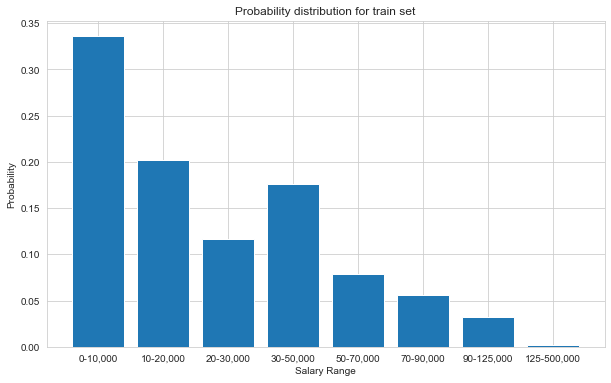

In [83]:
plt.figure(figsize=(10,6))
plt.bar(labels, probab_predict.iloc[2])
plt.xlabel('Salary Range')
plt.ylabel('Probability')
plt.title('Probability distribution for train set')
plt.show()  

Let us create a function that visualizes the accuracy of the models we are building. It plots as a continuous line the mean values of the scores of the chosen estimator for two data sets, and a coloured band around the mean line, i.e., the interval (mean - standard deviation, mean + standard deviation).

plot_learning_curve() uses in turn the function sklearn.learning_curve.learning_curve(), which determines cross-validated training and test scores for different training set sizes. An (optional) cross-validation generator splits the given dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. The scores are averaged over all k runs for each training subset size.

In [84]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

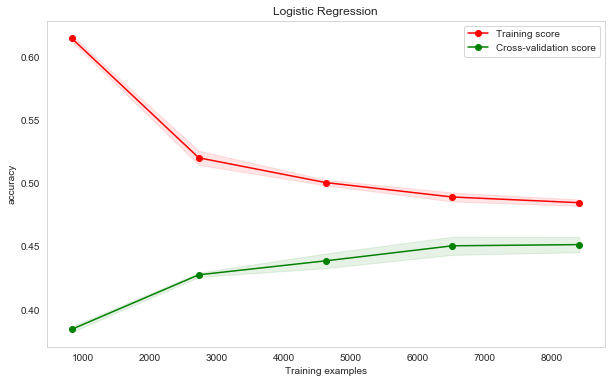

In [85]:
plot_learning_curve(model,'Logistic Regression', X1_train, y1_train, cv=5)
plt.show()

## Hyperparameter Tuning, Bias-Variance Tradeoff

Performing grid search to give the best hyperparameters. Grid search just builds several models with all the parameter combinations specified, and runs cross validation to return the set of parameters that had the highest cv score on the validation set.

As my penalty and c values can vary in a certain range, I am performing the hyperparameter tuning on those only. The tuning is done only on the training set which was originally split.

For bias and variance tradeoff the log loss error needs to be calculated and thus log loss error is calculated for various c and penalty values.

In [86]:
model = LogisticRegression(random_state = 0, multi_class='ovr')
scaler = StandardScaler()
kfold = KFold(n_splits=5)
kfold.get_n_splits(X1_train)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

train_error = np.zeros(20)
test_error = np.zeros(20)
j = 0
for C in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]:
    for penalty in ['l1', 'l2']:
        
        model = LogisticRegression(C=C, solver='saga', penalty = penalty, random_state = 0, multi_class='ovr')
        accuracy = np.zeros(5)
        trainErr = np.zeros(5)
        testErr = np.zeros(5)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X1_train):
            Xnew_train, Xnew_test = X1_train.values[train_idx], X1_train.values[test_idx]
            ynew_train, ynew_test = y1_train.values[train_idx], y1_train.values[test_idx]
    
            Xnew_train = scaler.fit_transform(Xnew_train)
            Xnew_test = scaler.transform(Xnew_test)
    
            model.fit(Xnew_train, ynew_train)
    
            predictions = model.predict_proba(Xnew_test)
            predictions_train = model.predict_proba(Xnew_train)
            
            predictions2 = model.predict(Xnew_test)
            
            trainErr[np_idx] = np.mean(log_loss(ynew_train, predictions_train))
            testErr[np_idx] = np.mean(log_loss(ynew_test, predictions))
    
            ACC = accuracy_score(ynew_test, predictions2)
    
            accuracy[np_idx] = ACC*100
            np_idx += 1
            
        train_error[j] = np.mean(trainErr)
        test_error[j] = np.mean(testErr)
        j += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'penalty':penalty}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} penalty, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['penalty'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.08, 'penalty': 'l2'}
Best Score: 44.997%(0.526%)

The optimal log model uses C=0.08, and a l2 penalty, and has a cross validation score of 44.997% with a standard deviation of 0.526%


The errors need to be reshaped as we got error for both the penalties and C values thus, reshaping them in (10, 2) the first column would give us errors for L1 penalty and the second column would give us errors for L2 penalty. Thus, plotting the log loss curves for both L1 and L2 penalty. 

In [87]:
train_error = train_error.reshape(10,2)
test_error = test_error.reshape(10,2)

Log Loss error plot for L1 Penalty

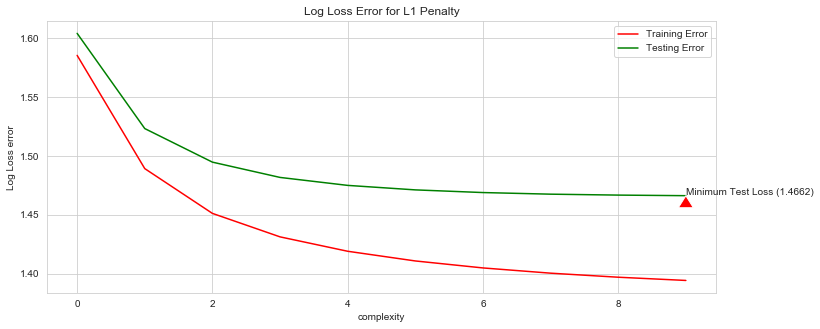

In [88]:
plt.figure(figsize=(12,5))


plt.plot(train_error[:,0],'r',label='Training Error')
plt.plot(test_error[:,0],'g',label='Testing Error')
# plt.plot(train_error[:,0] + test_error[:,0], 'b', label='Total Error')

test_loss_min = test_error[:,0].min()
deg_min = test_error[:,0].argmin()

#Annotate the plot:plt.annotate(text,pointing coordinates,text coordinates,arrowproperty={})
plt.annotate('Minimum Test Loss (%.4f)' % test_loss_min,xy=(deg_min,test_loss_min),xytext=(deg_min,test_loss_min+0.001),arrowprops=dict(width=3,headwidth=15,facecolor='r',shrink=0.05))

plt.title("Log Loss Error for L1 Penalty")
plt.xlabel("complexity")
plt.ylabel("Log Loss error")
plt.legend(loc=1)
plt.show()

Log Loss error plot for L2 Penalty

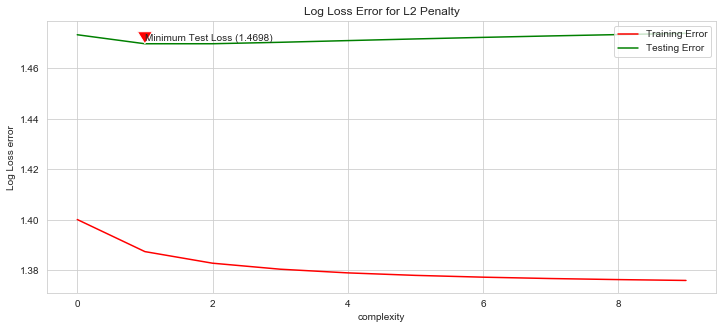

In [89]:
plt.figure(figsize=(12,5))


plt.plot(train_error[:,1],'r',label='Training Error')
plt.plot(test_error[:,1],'g',label='Testing Error')
# plt.plot(train_error[:,1] + test_error[:,1], 'b', label='Total Error')

test_loss_min = test_error[:,1].min()
deg_min = test_error[:,1].argmin()

#Annotate the plot:plt.annotate(text,pointing coordinates,text coordinates,arrowproperty={})
plt.annotate('Minimum Test Loss (%.4f)' % test_loss_min,xy=(deg_min,test_loss_min),xytext=(deg_min,test_loss_min+0.001),arrowprops=dict(width=5,headwidth=15,facecolor='r',shrink=0.05))

plt.title("Log Loss Error for L2 Penalty")
plt.xlabel("complexity")
plt.ylabel("Log Loss error")
plt.legend(loc=1)
plt.show()

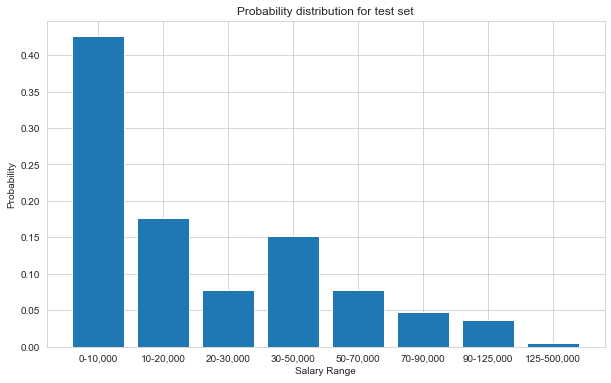

In [90]:
probab_predict_test1 = pd.DataFrame(model.predict_proba(X1_test), columns = model.classes_)
probab_predict_test1.head()

plt.figure(figsize=(10,6))
plt.bar(labels, probab_predict_test1.iloc[0])
plt.xlabel('Salary Range')
plt.ylabel('Probability')
plt.title('Probability distribution for test set')
plt.show()  

### Optimal Model Implementation

After Hyperparameter tuning I got C value = 0.08 and penalty as l2 which gives the best accuracy on cross validation, thus implementing the model with these parameters in the model and checking the accuracy on the previously split train and test data set. If I resplit the data with new values then there would be no apple to apple comaprison for accuracy on train set.

In [91]:
model1 = LogisticRegression(C=0.08, penalty='l2', random_state = 0, multi_class='ovr', solver='saga')
scaler = StandardScaler()
kfold = KFold(n_splits=5)
kfold.get_n_splits(X1_train)

accuracy = np.zeros(5)
accuracy_train = np.zeros(5)
np_idx = 0

for train_idx, test_idx in kfold.split(X1_train):
    Xnew1_train, Xnew1_test = X1_train.values[train_idx], X1_train.values[test_idx]
    ynew1_train, ynew1_test = y1_train.values[train_idx], y1_train.values[test_idx]
    
    Xnew1_train = scaler.fit_transform(Xnew1_train)
    Xnew1_test = scaler.transform(Xnew1_test)
    
    model.fit(Xnew1_train, ynew1_train)
    
    predictions_test = model.predict(Xnew1_test)
    predictions1_train = model.predict(Xnew1_train)
    
    ACC1 = accuracy_score(ynew1_test, predictions_test)
    ACC2 = accuracy_score(ynew1_train, predictions1_train)
    accuracy[np_idx] = ACC1*100
    accuracy_train[np_idx] = ACC2*100
    np_idx += 1
    
    print ("Fold {}:  Testing Accuracy: {}%".format(np_idx, round(ACC1*100,3)))
    print ("Fold {}:  Training Accuracy: {}%".format(np_idx, round(ACC2*100,3)))   

print ("Testing Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))
print ("Training Average Score: {}%({}%)".format(round(np.mean(accuracy_train),3),round(np.std(accuracy_train),3)))

Fold 1:  Testing Accuracy: 44.27%
Fold 1:  Training Accuracy: 48.627%
Fold 2:  Testing Accuracy: 45.839%
Fold 2:  Training Accuracy: 48.698%
Fold 3:  Testing Accuracy: 45.078%
Fold 3:  Training Accuracy: 48.817%
Fold 4:  Testing Accuracy: 44.983%
Fold 4:  Training Accuracy: 48.591%
Fold 5:  Testing Accuracy: 44.529%
Fold 5:  Training Accuracy: 48.692%
Testing Average Score: 44.94%(0.538%)
Training Average Score: 48.685%(0.077%)


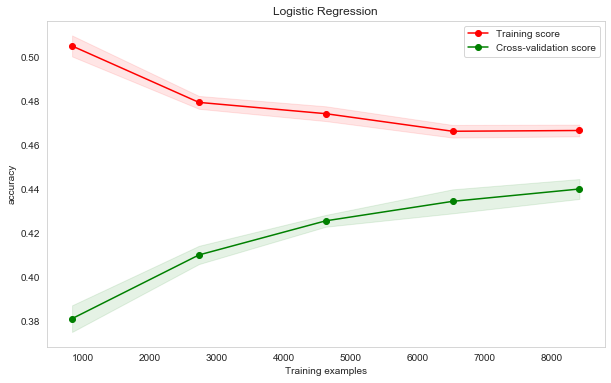

In [92]:
plot_learning_curve(model1,'Logistic Regression', X1_train, y1_train, cv=5)
plt.show()

### Model implementation on the testing set

In [93]:
model1 = LogisticRegression(C=0.08, penalty='l2', random_state = 0, multi_class='ovr', solver='saga')
scaler = StandardScaler()
X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)
model.fit(X1_train, y1_train)
predictions_test = model.predict(X1_test)
ACC_test = accuracy_score(y1_test, predictions_test)
print('Testing accuracy: {}%'.format(round(ACC_test*100,3)))

Testing accuracy: 44.474%


Testing accuracy is less than the training accuracy thus the model is not overfit, but it is underfitting the data set. The accuracy can still further be increased if the target classes are further clubbed, I tried with 5 classes in the target and I got an accuracy of 71%, but I chose not to take that as the classes were too wide and it will not predict the persons actual salary bucket and would give a vague idea which is not the good way to approach the task.

In [94]:
probab_predict_test = pd.DataFrame(model.predict_proba(X1_test), columns = model.classes_)
probab_predict_test.head()

,10000,20000,30000,40000,60000,80000,100000,150000
0,0.642558,0.136073,0.071475,0.092729,0.031421,0.014573,0.009610,0.001560
1,0.244226,0.130912,0.295237,0.297511,0.025867,0.005080,0.001113,0.000055
2,0.275649,0.230197,0.120963,0.115526,0.061353,0.025257,0.081502,0.089552
3,0.046256,0.322245,0.147841,0.095501,0.161670,0.028518,0.125974,0.071995
4,0.219943,0.242831,0.266522,0.156567,0.067842,0.018849,0.021778,0.005667


In [95]:
labels = ['0-10,000', '10-20,000', '20-30,000', '30-50,000', '50-70,000', '70-90,000', '90-125,000', '125-500,000']

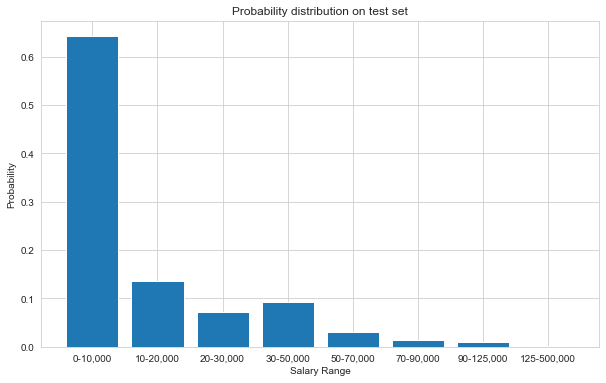

In [96]:
plt.figure(figsize=(10,6))
plt.bar(labels, probab_predict_test.iloc[0])
plt.xlabel('Salary Range')
plt.ylabel('Probability')
plt.title('Probability distribution on test set')
plt.show()  